In [1]:
import os

colab = 'COLAB_GPU' in os.environ
if colab:
    print("Running in Google Colab")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DRIVE_FOLDER = '/content/drive/MyDrive/Data/BikePricePredict/'

Running in Google Colab
Mounted at /content/drive


In [2]:
#!unzip /content/drive/MyDrive/Data/BikePricePredict/bicycles_all_keep_nodupes4_resized.zip -d /content/data/

Archive:  /content/drive/MyDrive/Data/BikePricePredict/bicycles_all_keep_nodupes4_resized.zip
replace /content/data/00004c6e-c371-330a-936b-7e1560048f66_375.50.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [4]:
def get_dataset_path_and_labels(dataset_path):
    labels = []
    files = []
    for file in os.listdir(dataset_path):
        if 'Steuern' in file:
          continue
        label = file.split('_')[-1].replace('.jpg','').replace('ÿ','').replace('ÿ','').replace('ab','').strip()
        labels.append(float(label))
        files.append(os.path.join(dataset_path, file))
    return files, labels

In [5]:

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    ''' # preprocess
    image = tf.image.resize(image, [256, 256])
    image /= 255.0 # normalize '''


    '''  # Flip the image horizontally
    flipped_image = tf.image.flip_left_right(image) '''

   
    
    # Add the augmented images to the dataset
    ''' images = tf.stack([image, flipped_image])
    labels = tf.stack([label, label, label]) '''

    return image, label





In [6]:
from tensorflow.keras import layers
import numpy as np

def get_dataset(dataset_path, skip, take, random_seed):
    
    files, labels = get_dataset_path_and_labels(dataset_path)

    shuffled_index = np.random.RandomState(seed=random_seed).permutation(len(files))
    take_index = shuffled_index[skip:skip+take]
    files = [files[i] for i in take_index]
    labels = [labels[i] for i in take_index]

    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(load_and_preprocess_image)
    return ds


import os

if colab:
    #dir = DRIVE_FOLDER+'bicycles_resized_1024_20k'
    dir = '/content/data/'
  
else:
    print("Running locally")


IMG_SIZE = 256
data_preprocessing = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.01),
  
])




test_size = 1000
dev_size = 1000


seed = 4
# no shuffling
test_dataset = get_dataset(dir, skip=0, take=test_size, random_seed=seed)
dev_dataset = get_dataset(dir, skip=test_size, take=dev_size, random_seed=seed)
train_dataset = get_dataset(dir, skip=test_size+dev_size, take=10000000, random_seed=seed)




train_dataset = train_dataset.map(lambda x, y : (data_preprocessing(x, training=True), y) )
dev_dataset = dev_dataset.map(lambda x, y : (data_preprocessing(x, training=False), y) )
test_dataset = test_dataset.map(lambda x, y : (data_preprocessing(x, training=False), y) )

In [7]:
len(train_dataset), len(dev_dataset), len(test_dataset)

(43573, 1000, 1000)

In [8]:
x, y = next(train_dataset.take(1).as_numpy_iterator())

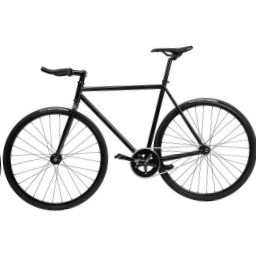

In [9]:
import PIL
# view x as image with PIL
PIL.Image.fromarray((x * 255).astype(np.uint8))

In [10]:
model2 = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False)
model2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                      

In [11]:
# count conv2d layers in model2
conv2d_indices = []
for i, layer in enumerate(model2.layers):
    if layer.name.endswith("conv"):
        conv2d_indices.append(i)

len(conv2d_indices)

53

In [12]:
53 * 0.25

13.25

In [13]:
 # each block has approximately 3 conv2d layers
idx  = -3*10 +1
model2.layers[conv2d_indices[idx]].name, conv2d_indices[idx]

('conv4_block1_1_conv', 88)

In [14]:
def save_weights(model, weights_path):
  for layer in model.layers:
    layer.trainable=False
  ''' for layer in base_model.layers:
    layer.trainable=False '''
  
  model.save(weights_path)

In [25]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.initializers import glorot_uniform

mixed_precision.set_global_policy('mixed_float16') # for faster computation see https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html
 # and see https://www.tensorflow.org/guide/mixed_precision

def make_model(base_model, unfreeze_start:int, weights_path=None, reset_weights=False):
  
  
    
    

  base_model.trainable = False

  inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = base_model(inputs, training=True) # training=True only enabled for unfrozen layers (?)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  ''' x = tf.keras.layers.Dense(256, activation='relu')(x) '''
  '''   x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x) '''
  outputs = tf.keras.layers.Dense(1, activation='relu')(x) # use relu because prices are always positive
  model = tf.keras.Model(inputs, outputs)

 
  if weights_path is not None:
    unfr = int(weights_path.split('unfr')[-1].split('_')[0])
    assert unfreeze_start == unfr

    model.load_weights(weights_path)

  # freeze base model
  for layer in base_model.layers[unfreeze_start:]: # last, conv5 section
    layer.trainable = True 

  # reset weights
  if reset_weights:
    for layer in model.layers:
      if hasattr(layer, 'kernel_initializer'):
          layer.kernel_initializer = glorot_uniform(seed=4)
          
      if hasattr(layer, 'bias_initializer'):
          layer.bias_initializer = glorot_uniform(seed=4)


  return model
  
# create keras resnet 50 v2 model
base_model = tf.keras.applications.ResNet101V2(include_top=False, weights='imagenet')
unfreeze_start = 0



In [31]:

#model = make_model(base_model, unfreeze_start, '/content/drive/MyDrive/Data/BikePricePredict/weights_unfr163_bs32_lr0.0001_ep200.h5')
model = make_model(base_model, unfreeze_start, reset_weights=True)

In [17]:
#model = make_model(base_model, unfreeze_start, DRIVE_FOLDER+'weights_unfr163_bs32_lr0.001_43k_1k_1k_256MAE_ep45.h5') 


AssertionError: ignored

In [ ]:
# save_weights(model, '/content/drive/MyDrive/Data/BikePricePredict/test.h5')

In [ ]:
# model = make_model(base_model, '/content/drive/MyDrive/Data/BikePricePredict/test.h5')

In [ ]:
import matplotlib.pyplot as plt
x,y = next(train_dataset.take(1000).batch(1000).as_numpy_iterator())

In [ ]:
plt.hist(y)
plt.title('bike prices')

In [32]:
import pandas as pd
def fit(model, dataset, dev_dataset, batch_size , epochs, save_after_epochs, start_epoch_num, lr, unfreeze_start,  custom_tag='', dir=DRIVE_FOLDER):
  # 
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr) # reinit on each "fit", since optimizer maintains internal state (e.g. weights/gradients)
  loss_scale_optimizer = mixed_precision.LossScaleOptimizer(optimizer) # automatic scaling of loss for backprop to avoid numerical over-/underflow with mixed precision

  # Best practise would be to not override the optimizer from the h5 file (e.g. momentum in adam)
  model.compile(optimizer=loss_scale_optimizer, #tf.keras.optimizers.Adam(learning_rate=lr ), # beta1, beta2, weight_decay
                loss=tf.keras.losses.MeanSquaredError(),  # loss_scale_optimizer
                metrics=['mse', 'mae'],
                jit_compile=True # speeds up by combining computation kernels, see https://www.tensorflow.org/xla
              )
  for ep in range(0, epochs, save_after_epochs):
    print(f'fit {ep+start_epoch_num}')
    histories = None
    with tf.device('/GPU:0'):
      for _ in range(save_after_epochs):
        history = model.fit(dataset.batch(batch_size), epochs=1)
        loss, mse, mae = model.evaluate(dev_dataset.batch(batch_size))
        print(f'dev mse: {mse}, mae: {mae}')
        if histories is None:
          histories = history.history
          histories['dev_mse'] = [mse]
          histories['dev_mae'] = [mae]
        else:
          for k, v in history.history.items():
            histories[k] += v
          histories['dev_mse'].append(mse)
          histories['dev_mae'].append(mae)

    # Convert the history to a Pandas DataFrame
    history_df = pd.DataFrame(histories)
    print(history_df)
    
    # Save the history to a CSV file
    #history_df.to_csv(dir+f'history_unfr{str(unfreeze_start)}_bs{str(batch_size)}_lr{str(lr)}_{custom_tag}_ep{str(ep+start_epoch_num)}.csv', index=False)
    #save_weights(model, dir+f'weights_unfr{str(unfreeze_start)}_bs{str(batch_size)}_lr{str(lr)}_{custom_tag}_ep{str(ep+start_epoch_num)}.h5')
    history_df.to_csv(dir+f'history_unfr{str(unfreeze_start)}_bs{str(batch_size)}_{custom_tag}_ep{str(ep+start_epoch_num)}.csv', index=False)
    save_weights(model, dir+f'weights_unfr{str(unfreeze_start)}_bs{str(batch_size)}_{custom_tag}_ep{str(ep+start_epoch_num)}.h5')
    

In [33]:
fit(model, dataset=train_dataset, dev_dataset=dev_dataset, batch_size=32, epochs=100000, save_after_epochs=5, start_epoch_num=0, lr=0.001, unfreeze_start = unfreeze_start, custom_tag='43k_1k_1k_256_RESNETV2_100_lr0_0001_ffirst50epochs_then_lr0_001')

fit 0
32/32 [==============================] - 173s 5s/step - loss: inf - mse: 6496429.0000 - mae: 1638.6852
dev mse: 6496429.0, mae: 1638.6851806640625
32/32 [==============================] - 3s 81ms/step - loss: inf - mse: 5291252.0000 - mae: 1540.2090
dev mse: 5291252.0, mae: 1540.208984375
32/32 [==============================] - 3s 83ms/step - loss: inf - mse: 4677458.0000 - mae: 1558.0060
dev mse: 4677458.0, mae: 1558.0059814453125
32/32 [==============================] - 4s 116ms/step - loss: inf - mse: 4404124.5000 - mae: 1588.6471
dev mse: 4404124.5, mae: 1588.6470947265625
32/32 [==============================] - 3s 86ms/step - loss: inf - mse: 4267794.0000 - mae: 1599.7085
dev mse: 4267794.0, mae: 1599.70849609375
   loss        mse          mae    dev_mse      dev_mae
0   inf  7100400.5  1768.644775  6496429.0  1638.685181
1   inf  5500224.0  1511.517090  5291252.0  1540.208984
2   inf  4640966.0  1485.686035  4677458.0  1558.005981
3   inf  4244595.0  1512.506470  4404124

KeyboardInterrupt: ignored

In [ ]:
x,y = next(test_dataset.take(10).batch(10).as_numpy_iterator())
model.predict(x)

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss(unfrozen_layers=None, lr:str=None, batch_size=None, minus_epochstart=0, custom_tag=None):
  y = []
  x = []
  for file in os.listdir(DRIVE_FOLDER):
    if ('unfr'+str(unfrozen_layers) in file or unfrozen_layers is None) and ('lr'+str(lr) in file or lr is None) and 'history' in file:
      if batch_size is not None:
        if 'bs'+str(batch_size) not in file:
          continue
      if custom_tag is not None:
        if custom_tag not in file:
          continue

      epochstart = file.split('ep')[-1].replace('.csv','')
      losses = pd.read_csv(DRIVE_FOLDER+file)['mse'].tolist() 
      xi = list(np.arange(len(losses)) +int(epochstart) - minus_epochstart)
      y += losses
      x += xi
  #plt.title(f'RESNET50 v2')
  
  label = f'lr:{lr}, bs:{batch_size}, unfr.lay.{unfrozen_layers},  {custom_tag if custom_tag is not None else ""}'
  plt.scatter(x, y, s = np.ones(len(y)), label=label)
  plt.legend()


  





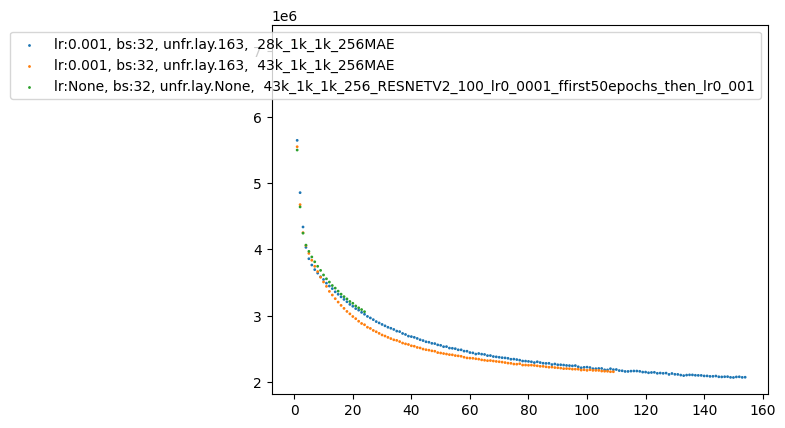

In [43]:
(
#plot_loss(163, '0.001', batch_size=32),
''' plot_loss(88, '0.001', batch_size=32), 
plot_loss(163, '0.0001', batch_size=32),
plot_loss(163, '0.001', batch_size=128),  
plot_loss(163, '0.003', minus_epochstart=100, batch_size=128), 
 ''',


#plot_loss(163, '0.001', batch_size=32, custom_tag='moredata'),
plot_loss(163, '0.001', batch_size=32, custom_tag='28k_1k_1k_256MAE'),
plot_loss(163, '0.001', batch_size=32, custom_tag='43k_1k_1k_256MAE'),
 
plot_loss( batch_size=32, custom_tag='43k_1k_1k_256_RESNETV2_100_lr0_0001_ffirst50epochs_then_lr0_001'),
)
plt.savefig(DRIVE_FOLDER+'temp.png')

In [ ]:
# best lr 0.001, best bs 32 (128, 32)
# 88 vs 163 (first pos of unfreeze) does not make a big difference

In [ ]:



# train model, specify batch size
batch_size = 128
epochs = 50
if colab:
  with tf.device('/GPU:0'):
      history = model.fit(dataset.batch(batch_size), epochs=epochs)
else:
  history = model.fit(dataset.batch(batch_size), epochs=epochs)

# plot history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [ ]:
# visualize part of the image which contributed most to the prediction
def visualize_heatmap(model, image):
    # get prediction
    prediction = model.predict(image[np.newaxis, ...])[0]
    # get gradient
    with tf.GradientTape() as tape:
        # cast image to float32
        inputs = tf.cast(image[np.newaxis, ...], tf.float32)
        # watch the input pixels
        tape.watch(inputs)
        # get the predictions
        predictions = model(inputs)
      
    print(predictions.shape)
    # get the gradient of the loss with respect to the inputs
    gradients = tape.gradient(predictions, inputs)
    # get the mean gradient across the channels
    gradient = tf.reduce_mean(gradients, axis=(0, 3))
    # get the mean prediction across the channels
    prediction = predictions#tf.reduce_mean(predictions, axis=3)[0]
    # scale the prediction
    prediction /= tf.reduce_max(prediction)
    # scale the gradient
    gradient /= tf.reduce_max(gradient)
    # upsample the prediction and the gradient
    prediction = tf.image.resize(prediction, [256, 256])
    gradient = tf.image.resize(gradient, [256, 256])
    # convert to numpy
    prediction = prediction.numpy()
    gradient = gradient.numpy()
    # plot the prediction and the gradient
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.imshow(prediction, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(gradient, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()

visualize_heatmap(model, x)